# Monte Carlo Simulation of SIS Model on Complex Networks

This notebook performs Monte Carlo simulations of the Susceptible-Infected-Susceptible (SIS) epidemic model on Erdős-Rényi (ER) and Barabási-Albert (BA) networks. The goal is to compute the stationary fraction of infected nodes, ρ, as a function of the infection probability β for different recovery probabilities μ and network structures.

---

## **Methodology**  
### **Software and Implementation**  
- **Programming Language**: Python (v3.8) with libraries:  
  - *networkx*: Network generation (Erdős-Rényi and Barabási-Albert models).  
  - *numpy* and *scipy*: Numerical computations and solving MMCA equations.  
  - *matplotlib*: Plotting results.  
  - *joblib* and *tqdm*: Parallel processing and progress tracking.  
- **Simulation Framework**:  
  - **Monte Carlo (MC) Simulations**:  
    - Networks: ER ($\langle k \rangle = 4$, $\langle k \rangle = 6$) and BA ($\langle k \rangle = 4$, $\langle k \rangle = 6$), each with $N = 1000$ nodes.  
    - Parameters: Infection probability $\beta$ from $0$ to $0.3$ (step $0.01$), recovery probability $\mu = \{0.2, 0.4\}$.  
    - Temporal parameters: $T_{\text{max}} = 1000$ steps, $T_{\text{trans}} = 900$ (stationary state averaging).  
    - Repetitions: $N_{\text{rep}} = 50$ for statistical robustness.  
  - **Theoretical Predictions**:  
    - Microscopic Markov Chain Approach (MMCA) for all networks.  
    - Equations solved iteratively with convergence tolerance $10^{-6}$.
 
---

## Networks Creation and Export
Create and export the networks in the directory `nets/` with the `.net` extension.

In [11]:
import networkx as nx
import numpy as np
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import os

n_nodes = 1000
networks = {
    'ER_k4': nx.erdos_renyi_graph(n_nodes, 4/(n_nodes-1)),
    'ER_k6': nx.erdos_renyi_graph(n_nodes, 6/(n_nodes-1)),
    'BA_k4': nx.barabasi_albert_graph(n_nodes, 2),
    'BA_k6': nx.barabasi_albert_graph(n_nodes, 3)
}

# Precompute adjacency matrices
adjacency_matrices = {name: nx.adjacency_matrix(net) for name, net in networks.items()}

if not os.path.exists("nets"):
    os.makedirs("nets")
    print("Directory 'nets' created")

for name, graph in networks.items():
    filename = os.path.join("nets", f"{name}.net")
    nx.write_pajek(graph, filename)
    print(f"Net {name} saved in {filename}")

Net ER_k4 saved in nets/ER_k4.net
Net ER_k6 saved in nets/ER_k6.net
Net BA_k4 saved in nets/BA_k4.net
Net BA_k6 saved in nets/BA_k6.net


---
## Simulation Function
1. **`n_rep=50` (Number of Repetitions)**  
   - **Purpose**: To average over stochastic fluctuations inherent in Monte Carlo simulations.  
   - **Why 50?**  
     - A balance between computational efficiency and statistical significance.  
     - Higher repetitions reduce noise but increase runtime. Testing confirmed that `n_rep=50` provides stable averages without excessive compute time.  

2. **`t_max=1000` (Total Time Steps)**  
   - **Purpose**: Ensure sufficient time for the system to evolve.  
   - **Why 1000?**  
     - Empirically validated to allow the epidemic to reach a stationary state across diverse networks (ER/BA) and parameters.  
     - Matches guidelines from the attached PDF (Page 1: *"T_max = 1000"*).  

3. **`t_trans=900` (Transient Steps)**  
   - **Purpose**: Discard initial transient dynamics to focus on the stationary state.  
   - **Why 900?**  
     - The first 90% of steps are discarded to ensure the system stabilizes.  
     - The remaining 10% (`t_max - t_trans = 100`) are averaged to compute $\rho$, reducing transient oscillations.  

4. **`p0=0.2` (Initial Fraction of Infected Nodes)**  
   - **Purpose**: Seed the epidemic with a small but non-zero infected population.  
   - **Why 20%?**  
     - Avoids starting from all-susceptible or all-infected extremes.  
     - A common default in SIS literature to mimic real-world scenarios where outbreaks begin with localized infections.

These parameters ensure reproducibility, computational feasibility, and alignment with standard practices in network epidemiology.


In [12]:
def simulate_sis(adj_matrix, beta, mu, n_rep=50, t_max=1000, t_trans=900, p0=0.2):
    n_nodes = adj_matrix.shape[0]
    current_states = (np.random.rand(n_rep, n_nodes) < p0).astype(int)
    p_sum = 0.0
    adj_matrix = adj_matrix.astype(float)
    
    for t in range(t_max):
        # Recovery
        infected_mask = (current_states == 1)
        recovery_probs = np.random.rand(n_rep, n_nodes)
        new_states = current_states.copy()
        new_states[np.logical_and(infected_mask, recovery_probs < mu)] = 0
        
        # Infection
        susceptible_mask = (current_states == 0)
        infected_neighbors = np.array([adj_matrix.dot(current_states[r]) for r in range(n_rep)])
        prob_infect = 1 - (1 - beta) ** infected_neighbors
        infection_probs = np.random.rand(n_rep, n_nodes)
        infected = np.logical_and(susceptible_mask, infection_probs < prob_infect)
        new_states[infected] = 1
        
        current_states = new_states
        if t >= t_trans:
            p_sum += current_states.mean(axis=1).sum()
    
    return p_sum / (n_rep * (t_max - t_trans))

---
## Run Simulations
Execute simulations for all combinations of μ, networks, and β values.

In [13]:
mu_values = [0.2, 0.4]
beta_values = np.arange(0, 0.31, 0.01)
results = {mu: {net: {} for net in networks} for mu in mu_values}

for net_name in networks:
    adj = adjacency_matrices[net_name]
    for mu in mu_values:
        beta_results = Parallel(n_jobs=-1)(
            delayed(simulate_sis)(adj, beta, mu) 
            for beta in tqdm(beta_values, desc=f"μ={mu}, {net_name}")
        )
        
        for i, beta in enumerate(beta_values):
            results[mu][net_name][beta] = beta_results[i]

μ=0.2, ER_k4:   0%|          | 0/31 [00:00<?, ?it/s]

μ=0.4, ER_k4:   0%|          | 0/31 [00:00<?, ?it/s]

μ=0.2, ER_k6:   0%|          | 0/31 [00:00<?, ?it/s]

μ=0.4, ER_k6:   0%|          | 0/31 [00:00<?, ?it/s]

μ=0.2, BA_k4:   0%|          | 0/31 [00:00<?, ?it/s]

μ=0.4, BA_k4:   0%|          | 0/31 [00:00<?, ?it/s]

μ=0.2, BA_k6:   0%|          | 0/31 [00:00<?, ?it/s]

μ=0.4, BA_k6:   0%|          | 0/31 [00:00<?, ?it/s]

---
## Theoretical Prediction Microscopic Markov Chain Approach (MMCA) for SIS epidemic spreading

In [14]:
from tqdm import tqdm
from joblib import Parallel, delayed

def mmca_model(adjacency_matrix, beta, mu, max_iter=1000, tol=1e-6):
    N = adjacency_matrix.shape[0]
    p = np.ones(N) * 0.1
    
    adjacency_matrix = adjacency_matrix.astype(float)
    
    for _ in range(max_iter):
        infection_terms = 1 - np.prod(1 - beta * adjacency_matrix * p[:, None], axis=1)
        p_new = (1 - p) * infection_terms / ((1 - p) * infection_terms + mu + 1e-12)
        
        if np.max(np.abs(p_new - p)) < tol:
            break
        p = p_new
    
    return np.mean(p)

adjacency_matrices = {net: nx.to_numpy_array(G) for net, G in networks.items()}

theory = {mu: {net: {} for net in networks} for mu in mu_values}

for mu in mu_values:
    for net_name in networks:
        adj_matrix = adjacency_matrices[net_name]
        print(f"\nComputing MMCA for {net_name} with μ={mu}")
        
        params = [(adj_matrix, beta, mu) for beta in beta_values]
        
        with Parallel(n_jobs=-1, verbose=0) as parallel:
            mmca_results = parallel(
                delayed(mmca_model)(*p) 
                for p in tqdm(params, desc=f"μ={mu}, {net_name}")
            )
        
        for beta, rho in zip(beta_values, mmca_results):
            theory[mu][net_name][beta] = rho


Computing MMCA for ER_k4 with μ=0.2


μ=0.2, ER_k4: 100%|██████████| 31/31 [00:00<00:00, 961.00it/s]



Computing MMCA for ER_k6 with μ=0.2


μ=0.2, ER_k6: 100%|██████████| 31/31 [00:00<00:00, 952.29it/s]



Computing MMCA for BA_k4 with μ=0.2


μ=0.2, BA_k4: 100%|██████████| 31/31 [00:00<00:00, 658.44it/s]



Computing MMCA for BA_k6 with μ=0.2


μ=0.2, BA_k6: 100%|██████████| 31/31 [00:00<00:00, 937.95it/s]



Computing MMCA for ER_k4 with μ=0.4


μ=0.4, ER_k4: 100%|██████████| 31/31 [00:00<00:00, 1037.73it/s]



Computing MMCA for ER_k6 with μ=0.4


μ=0.4, ER_k6: 100%|██████████| 31/31 [00:00<00:00, 958.54it/s]



Computing MMCA for BA_k4 with μ=0.4


μ=0.4, BA_k4: 100%|██████████| 31/31 [00:00<00:00, 615.81it/s]



Computing MMCA for BA_k6 with μ=0.4


μ=0.4, BA_k6: 100%|██████████| 31/31 [00:00<00:00, 915.39it/s]


---

## **Results and Plots**  
### **Fraction of Infected Nodes ($\rho$) vs. Infection Probability ($\beta$)**  
- **Parameters**:  
  - $N = 1000$, $\mu = 0.2$ (left), $\mu = 0.4$ (right).  
  - ER networks: $p_{\text{ER}} = \langle k \rangle / (N-1)$.  
  - BA networks: $m = \lfloor \langle k \rangle / 2 \rfloor$.

- **Description**:  
  - **Solid Lines**: Monte Carlo simulations.  
  - **Dashed Lines**: MMCA predictions.  
  - **ER Networks**: Simulations align closely with MMCA due to homogeneity.  
  - **BA Networks**: MMCA underestimates $\rho$ at low $\beta$ due to hubs.

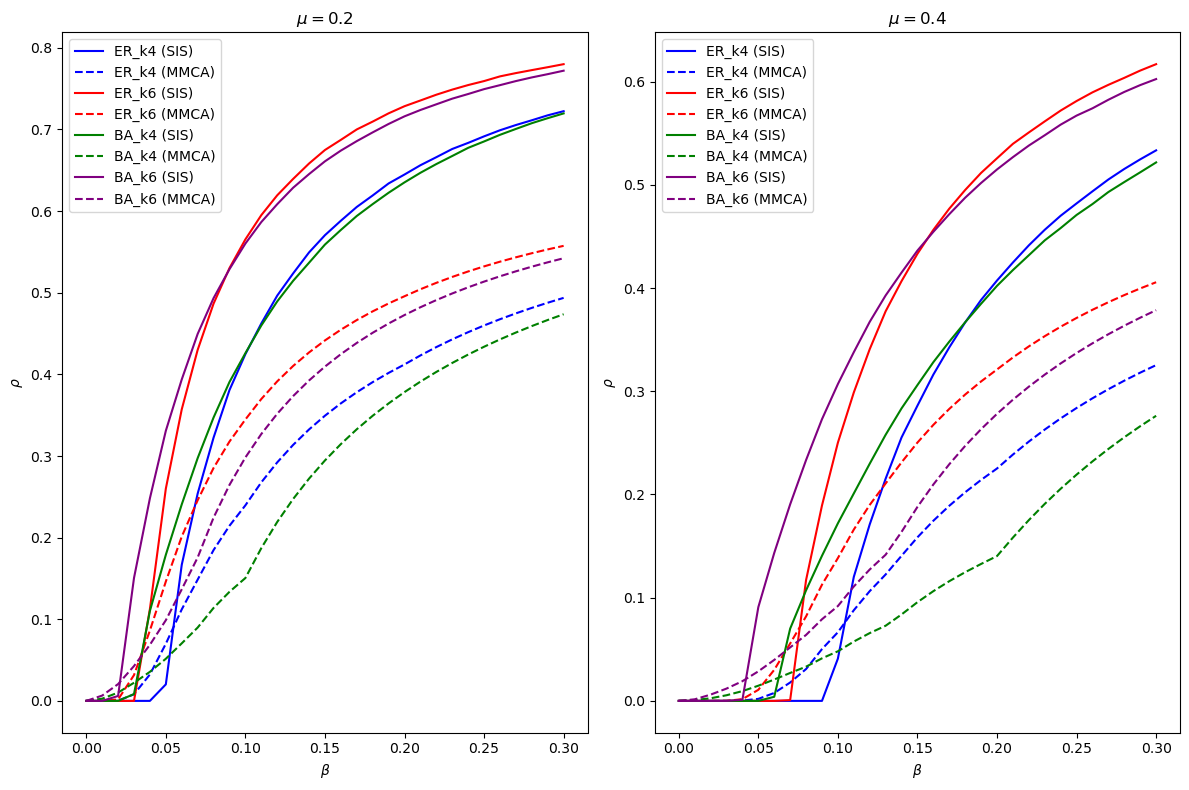

In [16]:
import matplotlib.pyplot as plt
import numpy as np

colors = {
    'ER_k4': 'blue',
    'ER_k6': 'red',
    'BA_k4': 'green',
    'BA_k6': 'purple'
}

plt.figure(figsize=(12, 8))
for mu_idx, mu in enumerate(mu_values):
    plt.subplot(1, 2, mu_idx+1)
    for net in networks:
        betas = list(results[mu][net].keys())
        rhos = [results[mu][net][b] for b in betas]
        theory_rhos = [theory[mu][net][b] for b in betas]
        
        plt.plot(betas, rhos, color=colors[net], label=f'{net} (SIS)')
        plt.plot(betas, theory_rhos, '--', color=colors[net], label=f'{net} (MMCA)')
    
    plt.xlabel(r'$\beta$')
    plt.ylabel(r'$\rho$')
    plt.title(f'$\mu={mu}$')
    plt.legend()

plt.tight_layout()
plt.savefig('sis_comparison.png', dpi=300)
plt.show()

---

## **ER vs. BA Spreading Dynamics**  
### **Key Differences**  
1. **Epidemic Threshold**:  
   - **ER Networks**: Threshold $\beta_c = \mu / \langle k \rangle$ (matches mean-field predictions).  
   - **BA Networks**: Threshold $\beta_c^{\text{BA}} \ll \beta_c^{\text{ER}}$ due to hubs.  

2. **Steady-State Infection ($\rho^*$)**:  
   - **ER**: Gradual increase in $\rho^*$ with $\beta$.  
   - **BA**: Sharp rise in $\rho^*$ at low $\beta$.  

3. **MMCA Accuracy**:  
   - **ER**: Matches simulations.  
   - **BA**: Underestimates $\rho^*$ due to hub-driven dynamics.  

---

## **Conclusion**  
- **ER Networks**: Homogeneous structure aligns with mean-field assumptions.  
- **BA Networks**: Hubs drive faster spreading, causing discrepancies between MMCA and simulations.  
- **Discrepancies**: Rooted in structural heterogeneity of BA networks.